# Cochlear Image Quality Classification
with DenseNet-121 model

*if using google colab, run following cells*

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
project_dir = '/content/drive/MyDrive/master_courses/BIDH5001 Capstone/Project/\
deep-classificataon'
os.chdir(project_dir)

In [ ]:
%pip install pydicom

*if running locally, start from here*

In [2]:
# imports
import datetime
import time
import tempfile
import warnings
import torch
import config
from dataio.dataloader import create_dataloader
from networks.densenet_classifier import densenet121_classifier
from training.evaluation import AccuracyEvaluator, LossEvaluator
from training.utility.progress_bar import ProgressBar
from training.utility.early_stopper import ValLoss as EarlyStopper
from training.utility.signal_control import SignalFileControl
import os
import re


# whenever possible, use cuda instead of cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    warnings.warn("torch is using CPU, as cuda is unavailable. this is inefficient.")
torch.set_default_device(device)

# paths to save and load state dictionary
load_sd = False
save_sd = True

bin_path = os.path.abspath("bin")
assert os.path.isdir(bin_path)

# if load_sd set True, load from state dict
sd_load_path = None
starting_epoch = 0
sd_file_pattern = r'densenet121_state_[0-9]{2}-[0-9]{2}-ep_[0-9]{2}\.pkl'
sd_epoch_pattern = r'densenet121_state_[0-9]{2}-[0-9]{2}-ep_([0-9]{2})\.pkl'
if load_sd:
    sd_files = [
        filename for filename in os.listdir(bin_path)
        if re.match(sd_file_pattern, filename)]
    sd_files.sort(reverse=True)
    if len(sd_files) > 0:
        sd_filename = sd_files[0]
        sd_load_path = os.path.join(bin_path, sd_filename) \
            if sd_filename is not None else None
        match = re.search(sd_epoch_pattern, sd_filename)
        starting_epoch = int(match.group(1))
        print(f'- loaded state from: {sd_filename}')
print(f"- starting from epoch: {starting_epoch + 1}")

# tempfile to save the model every time it reaches the best validation loss
state_dict_backup_path = tempfile.mktemp(prefix='state-dict_', suffix='.pth')

- starting from epoch: 1


### Training setup
**data:**
- read dicom paths and labels from the tracking table
- create corresponding training, validation and test dataloaders

**learning:**
- learning rate, epoches


*the data*

In [3]:
# reading from configurations
dicoms = config.dicom_paths # tracking_table['dicom_path'].to_list()
labels = config.labels # tracking_table['label'].astype('int16').to_list()

# initiate the dataloaders
dataloader_dict = create_dataloader(
    dicoms, labels,
    # dicom_dir = config.dicom_dir,
    batch_size = 8,
    validation_size = config.validation_size,
    test_size = config.test_size,
    img_size = (224, 224),
    use_3_channels = True,
)
training_dataloader, validation_dataloader, test_dataloader = \
    (dataloader_dict.get(key) for key in ('training_dataloader', 'validation_dataloader', 'test_dataloader'))

*the model*

In [4]:
# some settings, move to config in future
learning_rate = 0.00005 # 0.001 # 0.00005, originally without lr scheduler
n_epoches = 7
min_epoches = 3 # minimum epoches before early stopper allowed

# the classifier model
model = densenet121_classifier.to(device=device)
model.drop_rate = 0.2
# freeze all layers except for classifier
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all parameters
# # unfreeze parameters as follows
# # model.features.denseblock3.requires_grad = True
# # model.features.transition3.requires_grad = True
# model.features.denseblock4.requires_grad = True
# model.features.norm5.requires_grad = True
# model.classifier.requires_grad = True
# load state dict into the model
if load_sd and sd_load_path:
    state_dict = torch.load(sd_load_path)
    model.load_state_dict(state_dict)

# optimizers
# loss_function = torch.nn.CrossEntropyLoss() # (weight=torch.Tensor([0.1, 0.45, 0.45]).to(device))
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=learning_rate,
#     steps_per_epoch=len(training_dataloader), epochs=n_epoches,
#     )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.25
)
# scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 'min', factor=0.25, patience=1,
#     # threshold=0.05, threshold_mode='rel',
#     min_lr = learning_rate / 32,
#     cooldown=7,
# )
# scheduler = torch.optim.lr_scheduler.SequentialLR(
#     optimizer, schedulers=[scheduler_1, scheduler_2], milestones=[6])

# accuracy and loss evaluators
training_loss_evaluator = LossEvaluator(loss_function)
validation_loss_evaluator = LossEvaluator(loss_function)
validation_accuracy = AccuracyEvaluator()

best_epoch, best_loss = None, None

In [ ]:
learning_rate = 0.00025

In [6]:
# to continue training for n_epoches
n_epoches = 7

In [5]:
# evaluators for training/validation loss and accuracy
# training_loss = LossEvaluator(loss_function)
# validation_loss = LossEvaluator(loss_function)
# validation_accuracy = AccuracyEvaluator()
earlystopper = EarlyStopper(tolerance=3, target=0.1)
signalstopper = SignalFileControl()

# training epoches loop
for epoch in range(n_epoches):
    current_epoch = epoch + 1 + starting_epoch
    print(f'epoch # {current_epoch}')
    progress = ProgressBar(len(training_dataloader) + len(validation_dataloader))
    epoch_start_time = time.time()
    # reset pred and actual labels after each epoch
    validation_accuracy.reset()
    training_loss_evaluator.reset()
    validation_loss_evaluator.reset()
    
    # training network
    model.train()
    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        # train loss
        training_loss = loss_function(labels_pred, labels)
        # backpropagation
        optimizer.zero_grad()
        # training_loss.requires_grad = True
        training_loss.backward()
        optimizer.step()
        progress.step()
        training_loss_evaluator.append_loss(training_loss.item())
    
    # validating network
    model.eval()
    for images, labels in validation_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        validation_loss = loss_function(labels_pred, labels)
        validation_accuracy.append(labels_pred, labels)
        progress.step()
        validation_loss_evaluator.append_loss(validation_loss.item())
    epoch_end_time = time.time()
    # step scheduler
    scheduler.step() # (validation_loss_evaluator.value())
    print(
        f'train loss: {training_loss_evaluator}  \
        validation loss: {validation_loss_evaluator}  \
        validation accuracy: {validation_accuracy}')
    print(
        f'precision: {round(validation_accuracy.precision(), 3)}  \
        recall: {round(validation_accuracy.recall(), 3)}  \
        f1: {round(validation_accuracy.f1(), 3)}')
    # the evaluators have __str__
    print(
        f'duration: {round(epoch_end_time - epoch_start_time, 2)} s  \
        learning rate: {round(scheduler.get_last_lr()[0], 9)}')
    
    # if reaching best validation loss, back up the state
    if validation_loss_evaluator.is_best():
        best_epoch = current_epoch
        best_loss = validation_loss_evaluator.value()
        if save_sd and current_epoch > 1:
            # remove existing tempfile if exists
            os.remove(state_dict_backup_path) if os.path.isfile(state_dict_backup_path) else None
            torch.save(model.state_dict(), state_dict_backup_path)

    # step early stopper
    earlystopper.step(validation_loss_evaluator.value())
    print('-'*75)
    if earlystopper.stop() and epoch >= min_epoches:
        print('early stopper triggered, break')
        break
    if signalstopper.stop():
        print('signalled stop')
        break

signalstopper.reset()
# update the starting epoch number
starting_epoch = current_epoch
print('-' * 75)
if best_epoch is not None:
    print(f'best validation loss: {round(best_loss, 5)}, epoch {best_epoch}')
    print(f'saved to temp file: {state_dict_backup_path}')
else:
    print(f'validation loss does not improve')

signal file path: C:\Users\user\AppData\Local\Temp\signal-05-14-zvazeehz
epoch # 1
train loss: 0.271          validation loss: 0.309          validation accuracy: 85.71 %
precision: 0.48          recall: 0.857          f1: 0.615
duration: 77.2 s          learning rate: 5e-05
---------------------------------------------------------------------------
epoch # 2
train loss: 0.081          validation loss: 0.148          validation accuracy: 93.28 %
precision: 0.8          recall: 0.571          f1: 0.667
duration: 125.01 s          learning rate: 5e-05
---------------------------------------------------------------------------
epoch # 3
train loss: 0.036          validation loss: 0.119          validation accuracy: 93.28 %
precision: 0.8          recall: 0.571          f1: 0.667
duration: 99.1 s          learning rate: 1.25e-05
---------------------------------------------------------------------------
epoch # 4
train loss: 0.026          validation loss: 0.114          validation accurac

save state dict

In [7]:
# save model state_dicts to target path
sd_save_filename = f"densenet121_state_{datetime.datetime.now().strftime('%m-%d')}-ep_{current_epoch}.pkl"
sd_save_path = os.path.join(bin_path, sd_save_filename)
torch.save(model.state_dict(), sd_save_path)
print(f'state dict saved to path: {sd_save_path}')

state dict saved to path: g:\My Drive\master_courses\BIDH5001 Capstone\Project\deep-classification\bin\densenet121_state_04-30-ep_10.pkl


running on test set

In [5]:
test_loss_evaluator = LossEvaluator(criterion=loss_function)
test_accuracy_evaluator = AccuracyEvaluator()
saliency_image = None

for images, labels in test_dataloader:
    images = images.to(device=device)
    labels = labels.to(device=device)
    labels_pred = model(images)
    test_loss = loss_function(labels_pred, labels)
    test_loss_evaluator.append_loss(test_loss)
    test_accuracy_evaluator.append(labels_pred, labels)
    # obtain a saliency image with good image quality
    if saliency_image is None and torch.argmax(labels[0]).item() == 2:
        saliency_image = images
print(f'test loss: {test_loss_evaluator}\
    test accuracy: {test_accuracy_evaluator}')
print(
    f'precision: {round(test_accuracy_evaluator.precision(), 2)}  \
    recall: {round(test_accuracy_evaluator.recall(), 2)}  \
    f1: {round(test_accuracy_evaluator.f1(), 2)}')

test loss: 0.186    test accuracy: 91.38 %
precision: 0.75      recall: 0.5      f1: 0.6


### Visualization and Result Display

In [13]:
import pandas as pd

pd.Series(validation_accuracy.labels_actual).value_counts()

0    105
1     11
2      3
Name: count, dtype: int64

In [6]:
# print(validation_accuracy.labels_pred[:10])
print(validation_accuracy.labels_actual[:20])
print(validation_accuracy.labels_pred[:20])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1]
[1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
import pandas as pd

actual_pred_table = pd.DataFrame({
    'actual': validation_accuracy.labels_actual + test_accuracy_evaluator.labels_actual,
    'pred': validation_accuracy.labels_pred + test_accuracy_evaluator.labels_pred,
})
ap_table_path = os.path.join(
    r"D:\data\cochlear-project\tables", 'ap_table.csv'
)
actual_pred_table.to_csv(ap_table_path, index=False)

In [11]:
actual_lbl = validation_accuracy.labels_actual + test_accuracy_evaluator.labels_actual
len([_ for x in actual_lbl if x == 3])

4

In [1]:
# validation_accuracy.labels_actual[:20]
import matplotlib.pyplot as plt
from sklearn import metrics

labels_actual = validation_accuracy.labels_actual
labels_pred = validation_accuracy.labels_pred
cm_dict = {actual: {pred: 0 for pred in (1,2,3)} for actual in (1,2,3)}
for label_actual, label_pred in zip(labels_actual, labels_pred):
    cm_dict[label_actual][label_pred] += 1
confusion_matrix = metrics.confusion_matrix(labels_actual, labels_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])
cm_display.plot()
plt.show()

NameError: name 'validation_accuracy' is not defined

try to obtain gradient and saliency from the model

In [6]:
saliency_image.shape

torch.Size([1, 3, 224, 224])

In [25]:
# saliency_image = images[[0]]
# saliency_label_actual = labels[[0]]
saliency_image.requires_grad_()
saliency_label_pred = model(saliency_image)
saliency_label_actual = torch.Tensor([[0, 0, 1]]).to(device)
saliency_loss = loss_function(saliency_label_pred, saliency_label_actual)
saliency_loss.backward()
# _, saliency_map = torch.max(saliency_image.grad.data.abs(), dim=1)
saliency_map = saliency_image.grad.data.abs()[0][0]

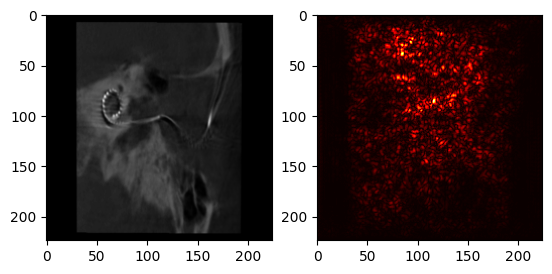

In [27]:
import matplotlib.pyplot as plt
# saliency_matrix = saliency_map[0].numpy()
_, axs = plt.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].imshow(saliency_image.to('cpu')[0][0].detach().numpy(), 'binary_r')
axs[1].imshow(saliency_map.to('cpu').detach().numpy(), plt.cm.hot)
plt.show()

need to fix, is image not cropped in preprocessing?

also, is saliency the same in RGB? if not, need to use

`python
torch.sum(saliency_image.grad.data.abs(), dim=1)
`

In [29]:
saliency_image.grad.data.abs().shape

torch.Size([1, 3, 224, 224])

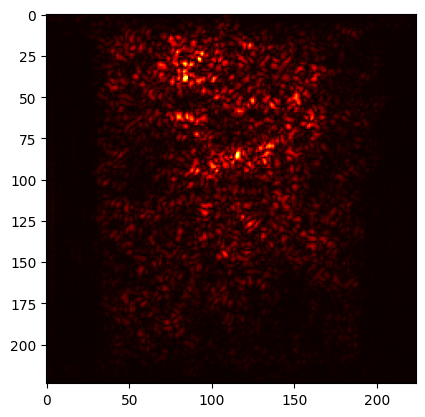

In [23]:
plt.imshow(saliency_image.grad.data.abs()[0][0].to('cpu'), plt.cm.hot)

In [15]:
labels

tensor([[1., 0., 0.]], device='cuda:0')

In [10]:
saliency_map.to('cpu')[0].numpy()

array([[0, 1, 1, ..., 2, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 2, 2, ..., 1, 0, 0],
       ...,
       [0, 2, 2, ..., 0, 0, 0],
       [2, 0, 0, ..., 1, 0, 0],
       [0, 1, 2, ..., 2, 0, 0]], dtype=int64)